In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc("text", usetex=True)
import scipy.fftpack as spfft

import sys
sys.path.insert(0, '../src/')

import kaczmarz
import scipy.io as sio
import scipy.linalg as splin
import time

## Load data

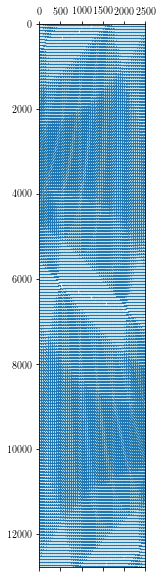

In [2]:
# matrix_data = sio.loadmat("./data/fancurved.mat")
matrix_data = sio.loadmat("../data/fanlinear.mat")
# matrix_data = sio.loadmat("./data/parallel.mat")

A = matrix_data["A"].toarray()
m, n = A.shape
plt.figure(figsize=(30, 10))
plt.spy(A, markersize=0.1)

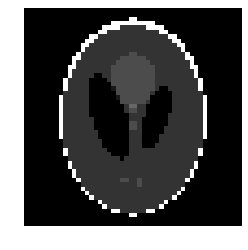

In [3]:
x_true = sio.loadmat("../data/shepplogan.mat")["x"]

n1d = int(np.sqrt(x_true.shape[0]))
im = np.reshape(x_true, (n1d, n1d), order="F")
plt.imshow(im, cmap="gray")
_ = plt.axis("off")

In [4]:
b = A.dot(x_true)
print(A.shape, b.shape)

(12780, 2500) (12780, 1)


## Check that the system is consistent

In [5]:
x_lstsq = np.linalg.lstsq(A, b, rcond=None)[0]
print(np.linalg.norm(A.dot(x_lstsq) - b) / np.linalg.norm(b))

1.9808450501663975e-15


In [7]:
preprocess_time = {
#     "$\gamma = 1$": 0,
    "$\gamma = 2$": 0,
    "$\gamma = 3$": 0,
}
sketch_sizes = [i * n for i in range(2, 4)]
P = {name: [] for name in preprocess_time}

## Create preconditioners from sketched submatrix

In [8]:
for k, i in enumerate(range(2, 4)):
    print("Sketch size = {}".format(n * i))
    st = time.time()
    sketch_idx = np.sort(np.random.choice(np.arange(m), sketch_sizes[k], replace=False))
    Q, R_qr = np.linalg.qr(A[sketch_idx, :])
#     print(np.linalg.cond(R_qr))
    try:
        P["$\gamma = {}$".format(i)] = np.linalg.inv(R_qr)
    except np.linalg.LinAlgError as err:
        print(err)
        P["$\gamma = {}$".format(i)] = np.linalg.pinv(R_qr, rcond=1e-6)
    preprocess_time["$\gamma = {}$".format(i)] = time.time() - st

Sketch size = 5000
Sketch size = 7500


## Initialize Kaczmarz method with and without preconditioners

In [28]:
# Maximum number of iterations
max_iter = 5000000000
# Required tolerance, but now is ignored
tol = 1e-6
x0 = np.zeros(n)
# Time of start using preconditioner.
# First ```start_prec``` seconds we run simple Kaczmarz method and 
# after this time run its preconditioned version to get high accurate solution 
start_prec = 120
# Maximum number of seconds for running considered methods
max_time = 480
# Store iterand every ```log_interval``` iterations
log_interval = 1000

In [10]:
test_methods = {}

In [12]:
test_methods["No preconditioning"] = kaczmarz.UniformKaczmarz(A, b)
_ = test_methods["No preconditioning"].solve(x0, max_iter, max_time=max_time, log_interval=log_interval)

In [13]:
for P_name in P:
    test_methods[P_name + ", start={}".format(start_prec)] = kaczmarz.UniformKaczmarz(A, b, P_right=P[P_name], 
                                    preprocess_time=preprocess_time[P_name], start_prec=start_prec)

In [14]:
for name in test_methods:
    if name == "No preconditioning":
        continue
    print(name)
    x = test_methods[name].solve(x0, max_iter, max_time=max_time, log_interval=log_interval)

$\gamma = 2$, start=120
$\gamma = 3$, start=120


## Plots

In [15]:
iter_range = {}

for i, name in enumerate(test_methods):
    size_iter = len(test_methods[name].get_convergence())
    iter_range[name] = [j * log_interval for j in range(size_iter)]

In [16]:
time_range = {}
for i, name in enumerate(test_methods):
    time_range[name] = [test_methods[name].get_time()[0]] + [t for j, t in enumerate(test_methods[name].get_time()) if (j+1) % log_interval == 0] + [test_methods[name].get_time()[-1]]

In [17]:
y_range = {}
for i, name in enumerate(test_methods):
    print(name)
    PR = test_methods[name]._P_right
    start_prec = test_methods[name]._start_prec
#     print(len(x))
    cur_y = []
#     print(iter_range[name])
    if PR is not None:
        y_woprec= []
        for j, x in enumerate(test_methods[name].get_convergence()):
#             print(x)
#             print(len(time_range[name]), len(test_methods[name].get_convergence()))
#             print(time_range[name][j])
            if time_range[name][j] - time_range[name][0] > start_prec:
                cur_y.append(np.linalg.norm(A.dot(PR.dot(x)) - b) / np.linalg.norm(b))
            else:
                cur_y.append(np.linalg.norm(A.dot(x) - b) / np.linalg.norm(b))
        y_range[name] = cur_y
    else:
        y_range[name] = [np.linalg.norm(A.dot(x) - b) / np.linalg.norm(b) 
                  for j, x in enumerate(test_methods[name].get_convergence())]

No preconditioning
$\gamma = 2$, start=120
$\gamma = 3$, start=120


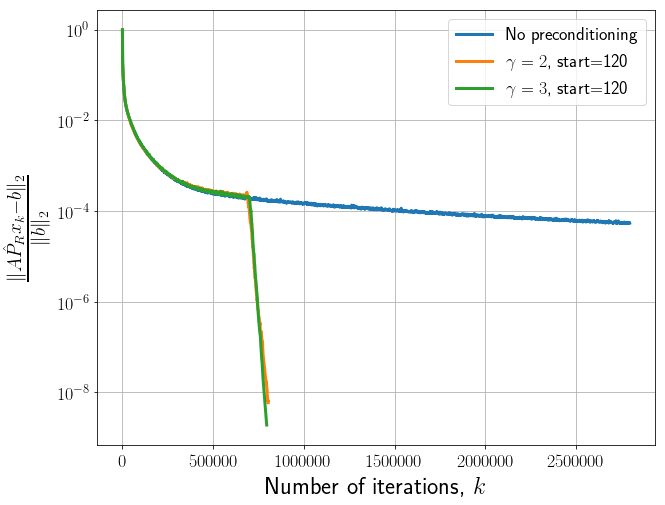

In [22]:
plt.figure(figsize=(10, 8))
markers = ["o", "*", "d", "."]

for i, name in enumerate(test_methods):
    plt.semilogy(iter_range[name], y_range[name],
                 label=name, 
                 linewidth=3, 
#                  marker=markers[i % 3], 
                 markersize=10)
plt.ylabel(r"$\frac{\|A\hat{P}_Rx_k - b\|_2}{\|b\|_2}$", fontsize=28)
plt.xlabel(r"Number of iterations, $k$", fontsize=24)
plt.legend(fontsize=18)
_ = plt.yticks(fontsize=18)
_ = plt.xticks(fontsize=18)
plt.grid(True)
# plt.xscale("log")

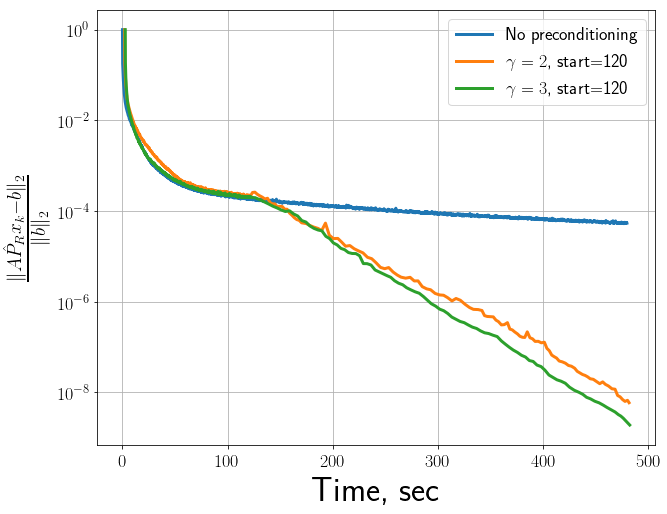

In [23]:
plt.figure(figsize=(10, 8))
markers = ["o", "*", "d", "."]

for i, name in enumerate(test_methods):
    plt.semilogy(time_range[name], y_range[name],
                 label=name, 
                 linewidth=3, 
                 markersize=10)
plt.ylabel(r"$\frac{\|A\hat{P}_Rx_k - b\|_2}{\|b\|_2}$", fontsize=28)
plt.xlabel(r"Time, sec", fontsize=34)
plt.legend(fontsize=18)
_ = plt.yticks(fontsize=18)
_ = plt.xticks(fontsize=18)
plt.grid(True)

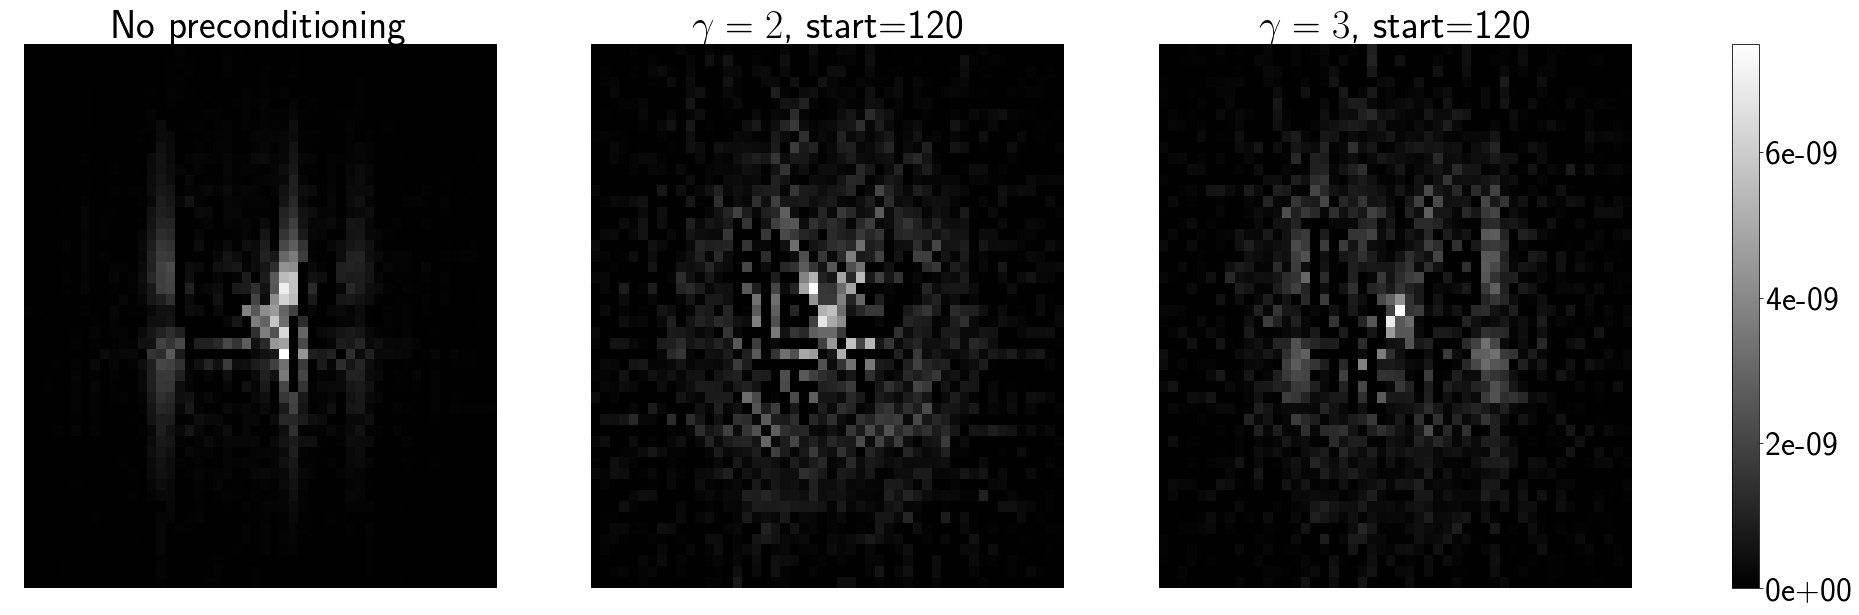

In [27]:
n1d = int(np.sqrt(A.shape[1]))
x_all = {}
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(36, 10))
for (i, name), ax in zip(enumerate(test_methods.keys()), axes.flat):
    PR = test_methods[name]._P_right
    if PR is None:
        x = test_methods[name].get_convergence()[-1]
    else:
        x = PR.dot(test_methods[name].get_convergence()[-1])
    x = np.clip(x, 0, 1)
    x_all[name] = np.reshape(x, (n1d, n1d), order="F")
    im_ax = ax.imshow(abs(x_all[name] - im) / np.linalg.norm(im), cmap="gray")
    ax.set_title(name, fontsize=40)
    ax.set_aspect("auto")
    ax.axis("off")

cbar = fig.colorbar(im_ax, ax=axes.ravel().tolist(), format='%.0e')
cbar.ax.tick_params(labelsize=34)